# Explore TAZ Segmentations Based on Functional Patterns
1. Explore patterns of different temporal cycles
2. Segment TAZs based on different temporal demand patterns (serve as semantic and similarity features)

In [1]:
# general import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional import
import geohash
import geopandas as gpd

# local import
from rdforecast import datasets

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = './input/'
# retrieve data from source url (if filepath is None)
data = datasets.load_training_data(filepath=path+'training.csv')
data = datasets.check_sanity(data)
# add_time may be deprecated after pandas 0.24.1
data = datasets.process_timestamp(data, add_time=True)
data.head()

Data loaded.
TAZ: 1329
N: 4206321
  geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
No missing values found.
First day in sequence: 1
Last day in sequence: 61


/Users/Yuwen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  


,geohash6,day,timestamp,demand,timestep,weekly,quarter,hour,dow,time
0,qp03wc,18,20:0,0.020072,1712,368,80,20,4,20:00:00
1,qp03pn,10,14:30,0.024721,922,250,58,14,3,14:30:00
2,qp09sw,9,6:15,0.102821,793,121,25,6,2,06:15:00
3,qp0991,32,5:0,0.088755,2996,308,20,5,4,05:00:00
4,qp090q,15,4:0,0.074468,1360,16,16,4,1,04:00:00


In [3]:
# create counts mapper per TAZ
counts = data['geohash6'].value_counts()
counts = dict(zip(counts.index, counts.values))
max_count = data['day'].max() * 24 * 4

# 1. Demand Patterns
1. Day of week (DOW) pattern (weekly cycle mean)
2. Daily pattern (throughout 2 months)
3. Quarterly (15-min timestep) pattern (daily cycle mean)

## 1.1 DOW demands per TAZ
- Timezone may need to be adjusted (roughly +0600 HRS for actual time)

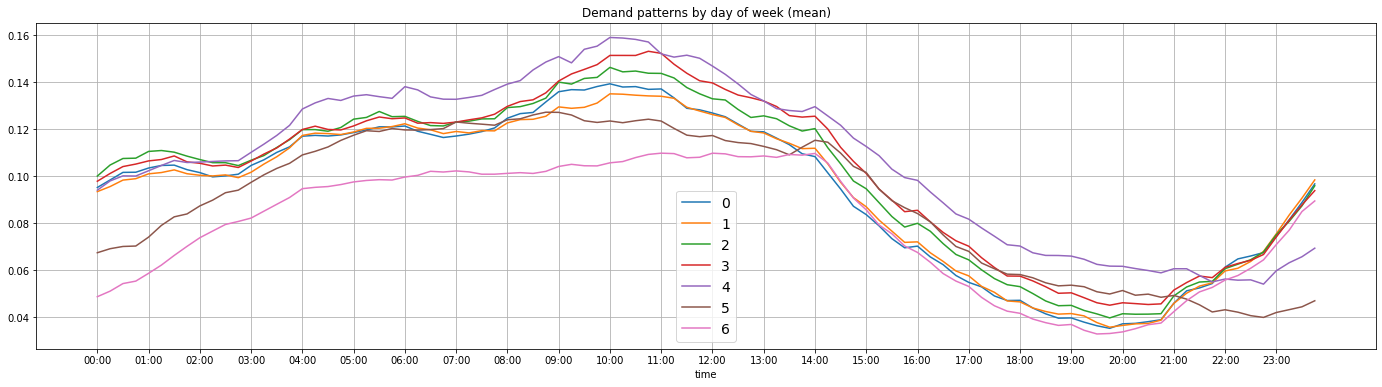

In [4]:
dow_demand = data.groupby(['dow', 'time']).mean()['demand'].reset_index()

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(111)
for i in range(7):
    tmp = dow_demand[dow_demand['dow'] == i]
    ax.plot(tmp['time'], tmp['demand'], label=i)
plt.title('Demand patterns by day of week (mean)')
plt.xticks(range(0,86400,3600))
plt.legend(fontsize=14)
plt.grid()
plt.show()

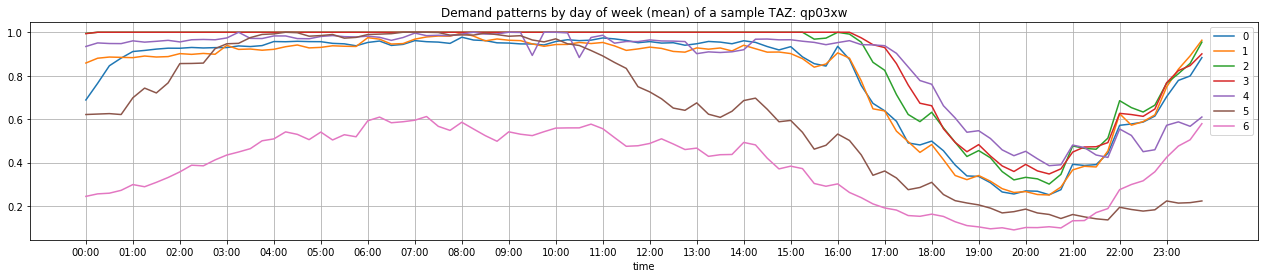

In [5]:
# plot some sample TAZs
taz_activity = data['geohash6'].value_counts()
sample = taz_activity.index[0]
sample_taz = data[data['geohash6'] == sample]
dow_demand = sample_taz.groupby(['dow', 'time']).mean()['demand'].reset_index()

fig = plt.figure(figsize=(22,4))
ax = fig.add_subplot(111)
for i in range(7):
    tmp = dow_demand[dow_demand['dow'] == i]
    ax.plot(tmp['time'], tmp['demand'], label=i)
plt.title('Demand patterns by day of week (mean) of a sample TAZ: ' + sample)
plt.xticks(range(0,86400,3600))
plt.legend()
plt.grid()

## 1.2 Daily demands per TAZ

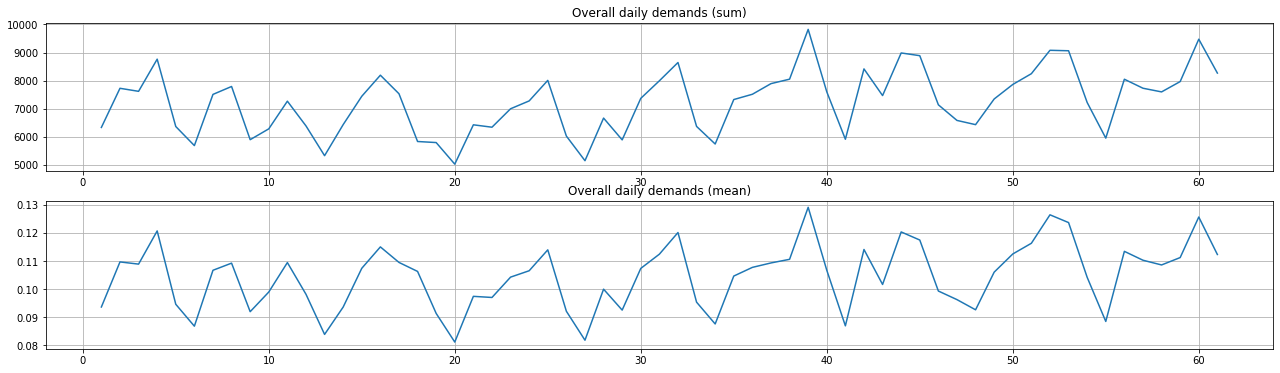

In [6]:
daily_demand_sum = data.groupby('day').sum()['demand']
daily_demand_mean = data.groupby('day').mean()['demand']

fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(daily_demand_sum)
ax2.plot(daily_demand_mean)
ax1.set_title('Overall daily demands (sum)')
ax2.set_title('Overall daily demands (mean)')
ax1.grid()
ax2.grid()
plt.show()

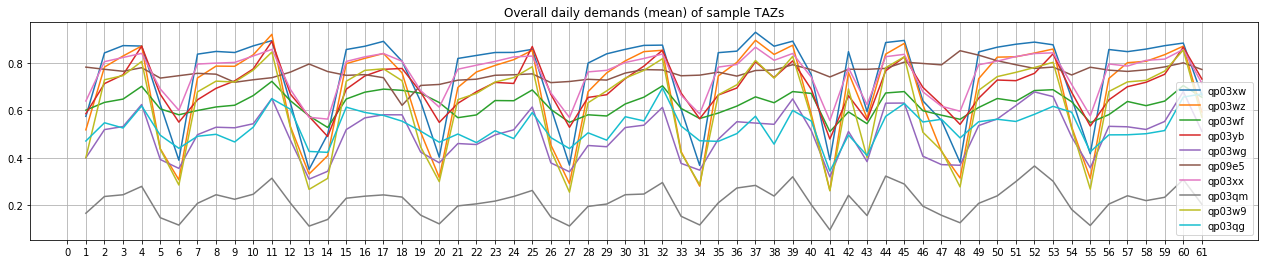

In [7]:
# plot some sample TAZs
taz_activity = data['geohash6'].value_counts()
samples = taz_activity.index[:10]

plt.figure(figsize=(22,4))
for sample in samples:
    sample_taz = data[data['geohash6'] == sample]
    daily_demand = sample_taz.groupby(['day']).mean()
    plt.plot(daily_demand['demand'], label=sample)
plt.title('Overall daily demands (mean) of sample TAZs')
plt.xticks(range(62))
plt.legend()
plt.grid()

## 1.3 Hourly demands per TAZ

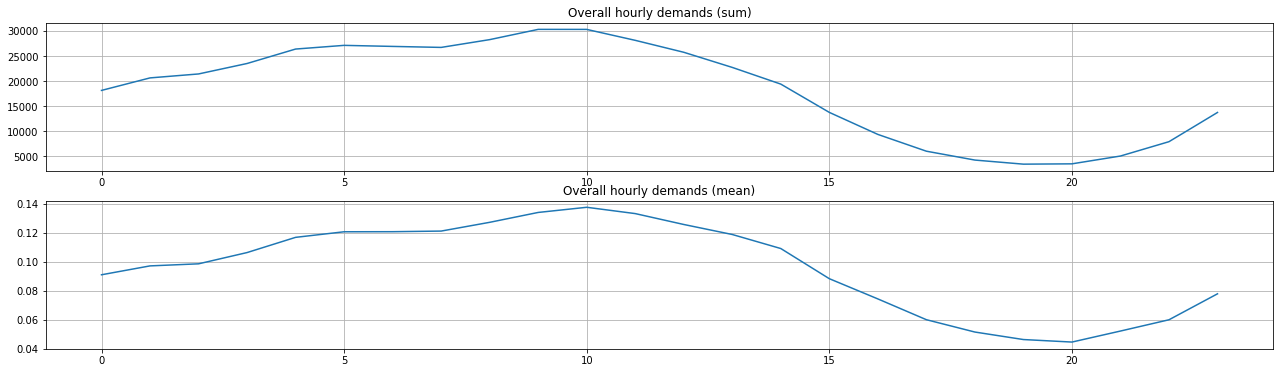

In [8]:
hourly_demand_sum = data.groupby('hour').sum()['demand']
hourly_demand_mean = data.groupby('hour').mean()['demand']

fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(hourly_demand_sum)
ax2.plot(hourly_demand_mean)
ax1.set_title('Overall hourly demands (sum)')
ax2.set_title('Overall hourly demands (mean)')
ax1.grid()
ax2.grid()
plt.show()

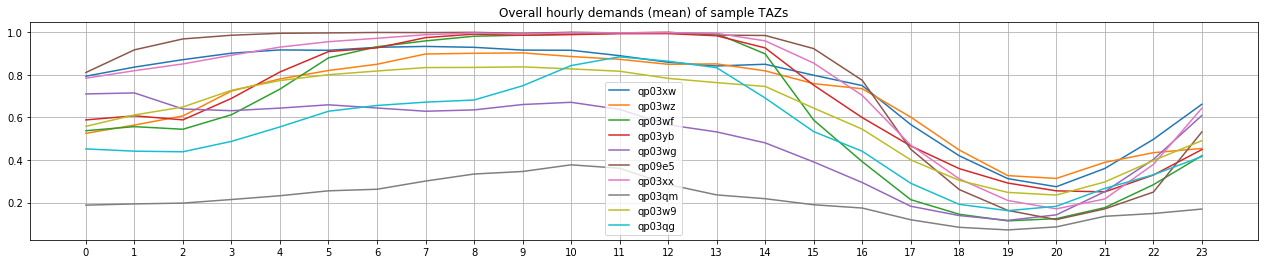

In [9]:
# plot some sample TAZs
taz_activity = data['geohash6'].value_counts()
samples = taz_activity.index[:10]

plt.figure(figsize=(22,4))
for sample in samples:
    sample_taz = data[data['geohash6'] == sample]
    hourly_demand = sample_taz.groupby(['hour']).mean()
    plt.plot(hourly_demand['demand'], label=sample)
plt.title('Overall hourly demands (mean) of sample TAZs')
plt.xticks(range(24))
plt.legend()
plt.grid()

# 2. Segment TAZs with Respective Temporal Patterns
- K-means
    1. weekly
    2. daily
    3. hourly

## 2.1 Functions

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def normalize_taz(df):
    tazmean = df.mean(axis=1)
    tazstd = df.std(axis=1)
    return df.apply(lambda x: (x - tazmean) / tazstd)

def check_clusters(df, n_features, s=2, e=15, random_state=2019):
    X = df.iloc[:, :n_features]
    sil = []
    SSE = []
    for n_clusters in range(s, e):
        km = KMeans(n_clusters=n_clusters, random_state=random_state)
        res = km.fit(X)  
        sil.append(silhouette_score(X, res.labels_))
        SSE.append(res.inertia_)
    # print('Silhouette:', sil)
    # print('SSE:', SSE)
    
    # plot results
    fig = plt.figure(figsize=(8,8))
    
    ax1 = fig.add_subplot(211)
    ax1.plot(range(s, e), sil)
    ax1.set_title('Silhouette scores vs. number of clusters')
    ax1.set_xlabel('Clusters')
    ax1.set_ylabel('Silhouette scores')

    ax2 = fig.add_subplot(212)
    ax2.plot(range(s, e), SSE)
    ax2.set_title('SSE vs. number of clusters')
    ax2.set_xlabel('Clusters')
    ax2.set_ylabel('Sum of squared errors')
    
    plt.tight_layout()
    plt.show()
    
def apply_cluster(df, n_timesteps, n_features, n_clusters, cluster_name, tickstep=4, random_state=2019):
    """Apply K-means clustering and plot results."""
    # check features
    print('Last 3 features:', df.columns[:n_features][-3:])
    
    # run K-means and assign results
    km = KMeans(n_clusters=n_clusters, random_state=random_state)
    res = km.fit(df.iloc[:, :n_features])
    colname = '{}_label_{}'.format(cluster_name, n_clusters)
    df[colname] = res.labels_
    
    # plot results
    plt.figure(figsize=(16,10))

    for l in range(n_clusters):
        # subset df and calculate means for each label
        df_ = df[df[colname] == l]
        df_means = df_.mean(axis=0)
        
        plt.subplot(np.ceil(n_clusters / 2), 2, 1 + l)
        for i in range(len(df_)):
            plt.plot(range(n_timesteps), df_.iloc[i, :n_timesteps], 'steelblue', alpha=0.2)
            plt.plot(range(n_timesteps), df_means[:n_timesteps], 'indianred', linewidth=2)
        plt.xticks(np.arange(0, n_timesteps, tickstep), rotation=45)
        plt.title('KM Cluster Label: {} (n = {})'.format(l, len(df_)))

    plt.tight_layout()
    plt.show()
    
def plot_cluster_map(shp, df, cluster_name, n_clusters):
    label_mapper = dict(zip(df.index,
                            df['{}_label_{}'.format(cluster_name, n_clusters)]))
    shp['label'] = shp['geohash6'].map(label_mapper)
    shp.plot(column='label', cmap='tab10', legend=True, categorical=True, figsize=(24,10));

## 2.2 Data

In [11]:
# this shapefile is for result visualization
# it can be generated from explore_spatial_lag.ipynb
shp = gpd.read_file('input/shapefiles/taz.shp')
shp['activity'] = shp['geohash6'].map(counts)

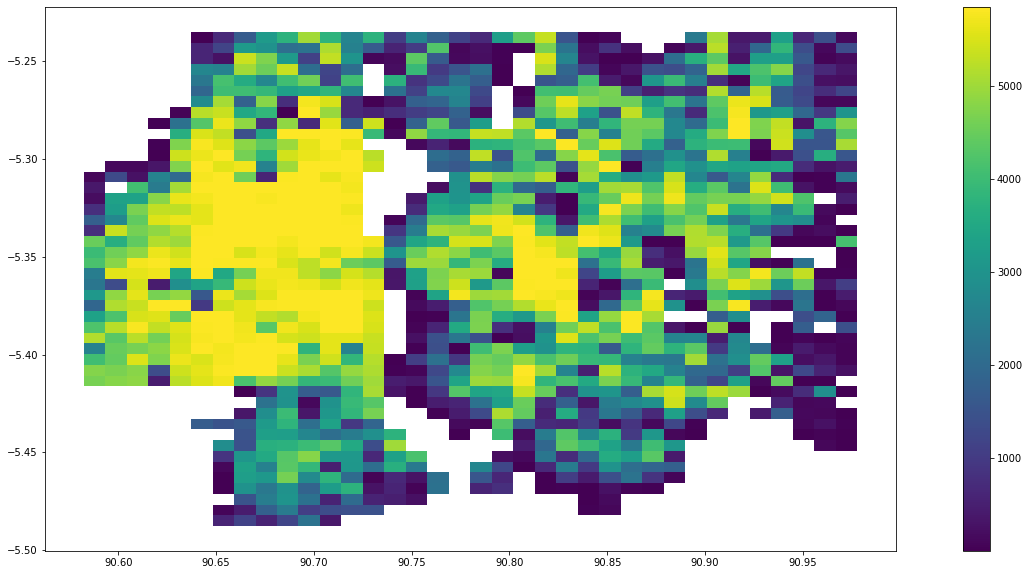

In [12]:
# plot global activity (days active per TAZ)
shp.plot(column='activity', cmap='viridis', legend=True, figsize=(24,10));

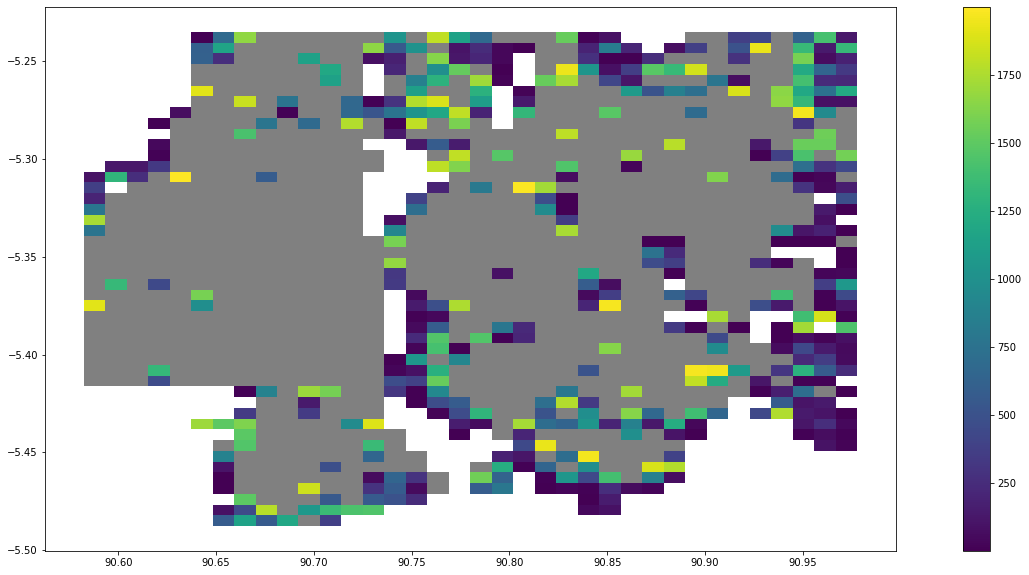

In [13]:
# plot low demand TAZs
ax = shp.plot(color='gray', figsize=(24,10))
shp[shp['activity'] <= 2000].plot(column='activity', cmap='viridis', legend=True, ax=ax);

## 2.3 Clustering

### 2.3.1 Weekly

In [14]:
taz_weekly = data.groupby(['geohash6', 'weekly'])['demand'].mean().unstack()
taz_weekly.fillna(0, inplace=True)
assert sum(taz_weekly.sum(axis=1) == 0) == 0
taz_weekly['active_count'] = taz_weekly.index.map(counts) / max_count
taz_weekly.head(1)

weekly,0,1,2,3,4,5,6,7,8,9,...,663,664,665,666,667,668,669,670,671,active_count
geohash6,,,,,,,,,,,,,,,,,,,,,
qp02yc,0.010381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008417,0.009744,...,0.0,0.0,0.0,0.0,0.0,0.013851,0.0,0.0,0.010264,0.098531


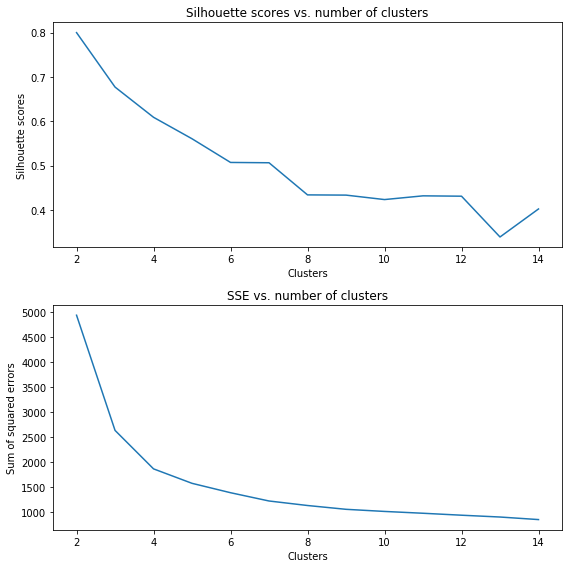

In [15]:
check_clusters(taz_weekly, n_features=672)

Last 3 features: Index([669, 670, 671], dtype='object', name='weekly')


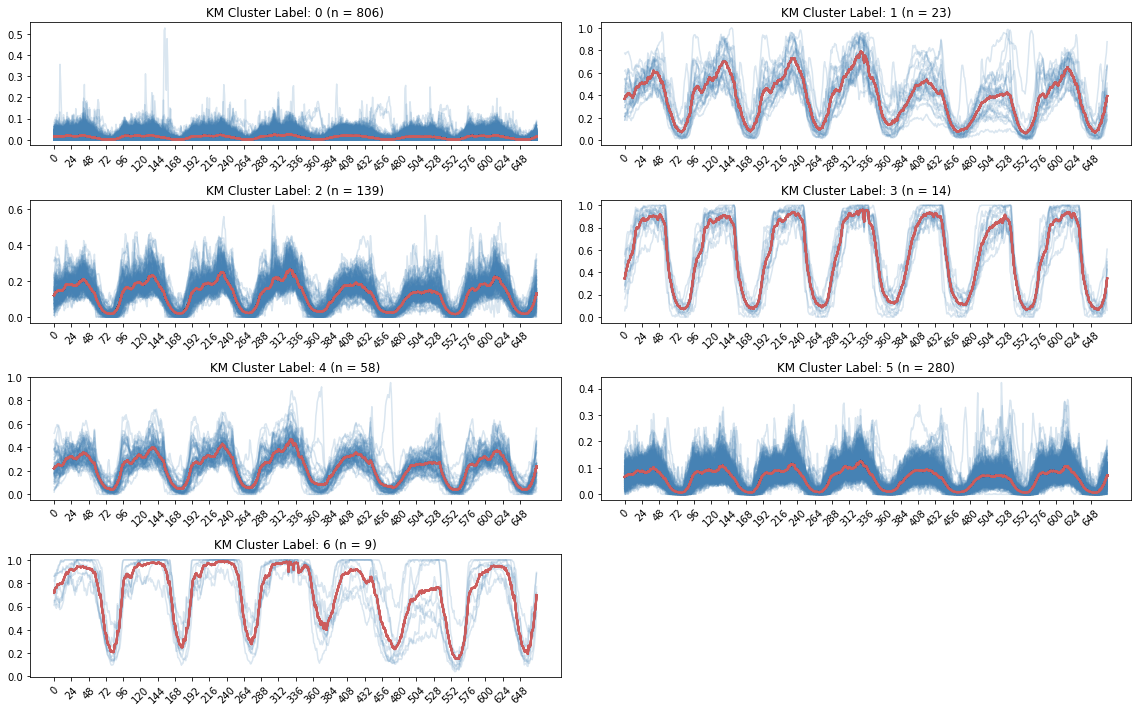

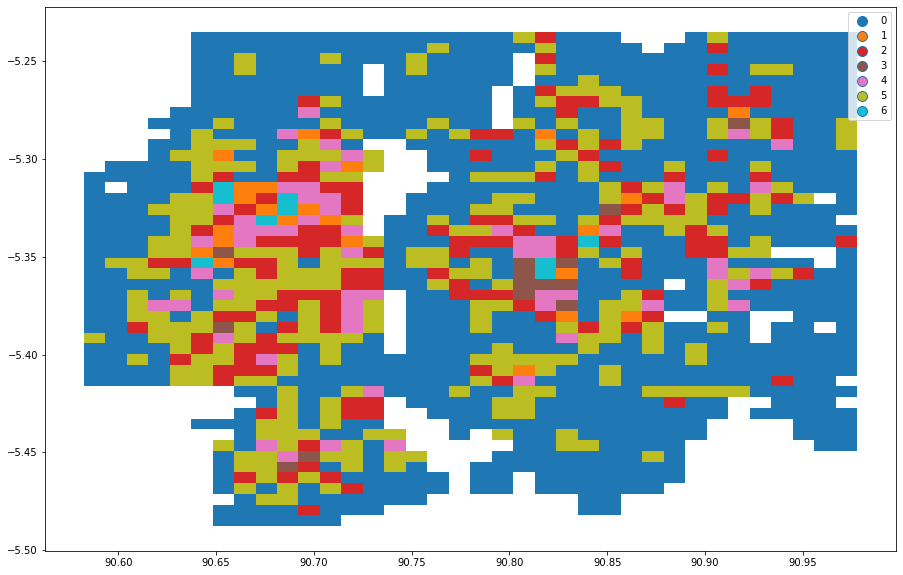

In [16]:
n_timesteps = 672
n_features = 672
n_clusters = 7
cluster_name = 'weekly'
apply_cluster(taz_weekly, n_timesteps, n_features, n_clusters, cluster_name, tickstep=24)
plot_cluster_map(shp, taz_weekly, cluster_name, n_clusters)

In [17]:
# get normalized demand pattern
taz_weekly_norm = data.groupby(['geohash6', 'weekly'])['demand'].mean().unstack()
taz_weekly_norm.fillna(0, inplace=True)
assert sum(taz_weekly_norm.sum(axis=1) == 0) == 0
taz_weekly_norm = normalize_taz(taz_weekly_norm)
taz_weekly_norm['active_count'] = taz_weekly_norm.index.map(counts) / max_count
taz_weekly_norm.head(1)

weekly,0,1,2,3,4,5,6,7,8,9,...,663,664,665,666,667,668,669,670,671,active_count
geohash6,,,,,,,,,,,,,,,,,,,,,
qp02yc,0.032356,-0.603062,-0.603062,-0.603062,-0.603062,-0.603062,-0.603062,-0.603062,-0.087834,-0.006599,...,-0.603062,-0.603062,-0.603062,-0.603062,-0.603062,0.244785,-0.603062,-0.603062,0.025203,0.098531


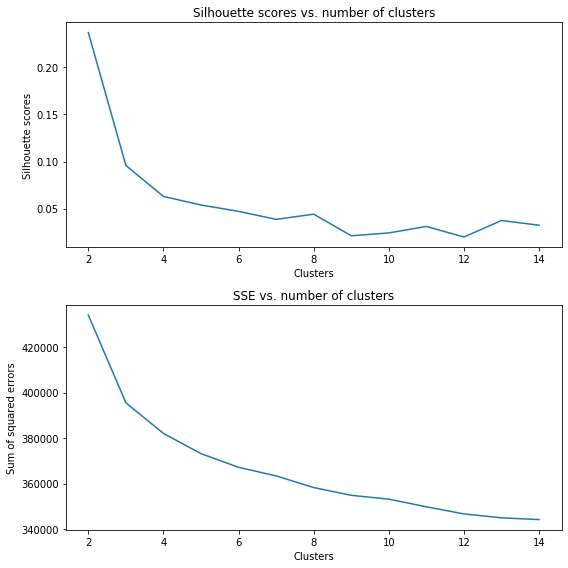

In [18]:
check_clusters(taz_weekly_norm, n_features=672)

Last 3 features: Index([669, 670, 671], dtype='object', name='weekly')


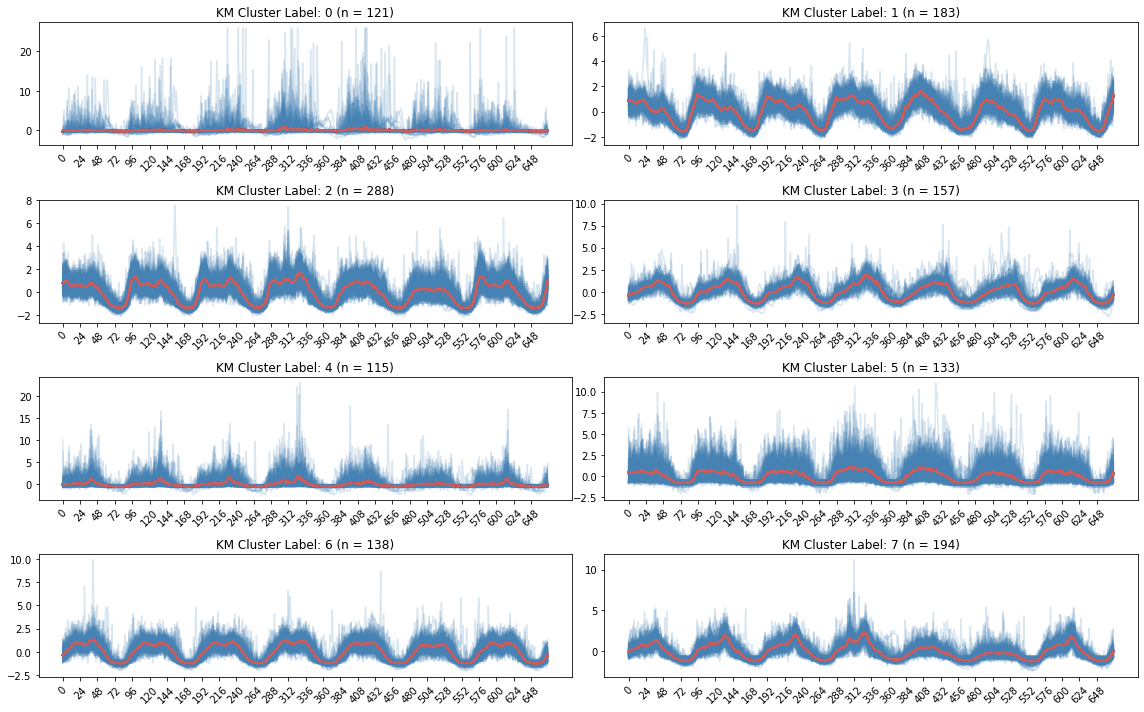

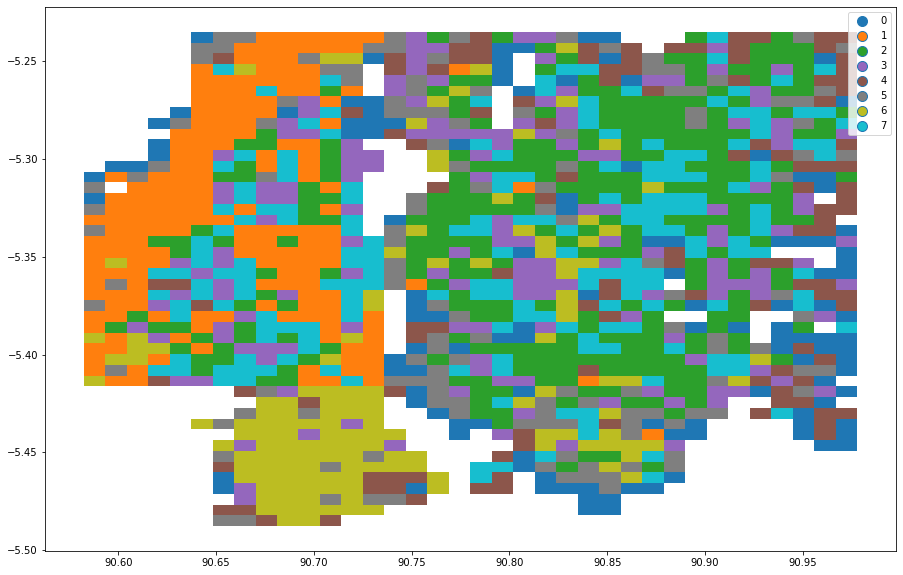

In [19]:
n_timesteps = 672
n_features = 672
n_clusters = 8
cluster_name = 'weekly_norm'
apply_cluster(taz_weekly_norm, n_timesteps, n_features, n_clusters, cluster_name, tickstep=24)
plot_cluster_map(shp, taz_weekly_norm, cluster_name, n_clusters)

### 2.3.2 Daily

In [20]:
taz_daily = data.groupby(['geohash6', 'day'])['demand'].mean().reset_index()
taz_daily = taz_daily.pivot(index='geohash6', columns='day', values='demand')
taz_daily.fillna(0, inplace=True)
assert sum(taz_daily.sum(axis=1) == 0) == 0
taz_daily = normalize_taz(taz_daily)
taz_daily['active_count'] = taz_daily.index.map(counts) / max_count
taz_daily.head(1)

day,1,2,3,4,5,6,7,8,9,10,...,53,54,55,56,57,58,59,60,61,active_count
geohash6,,,,,,,,,,,,,,,,,,,,,
qp02yc,-1.373073,0.170734,-0.447731,0.06679,-0.465741,-0.557373,0.185095,0.100484,-0.164673,-1.158675,...,0.400954,0.016292,-0.050179,0.264736,-0.038744,-0.060997,1.347398,0.512912,0.239749,0.098531


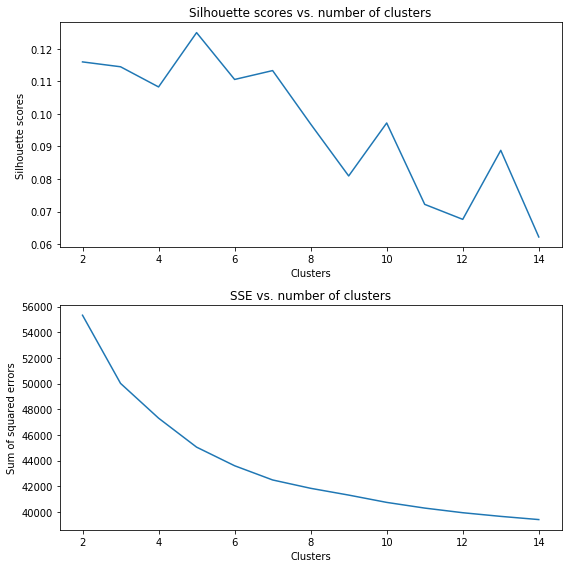

In [21]:
check_clusters(taz_daily, n_features=61)

Last 3 features: Index([59, 60, 61], dtype='object', name='day')


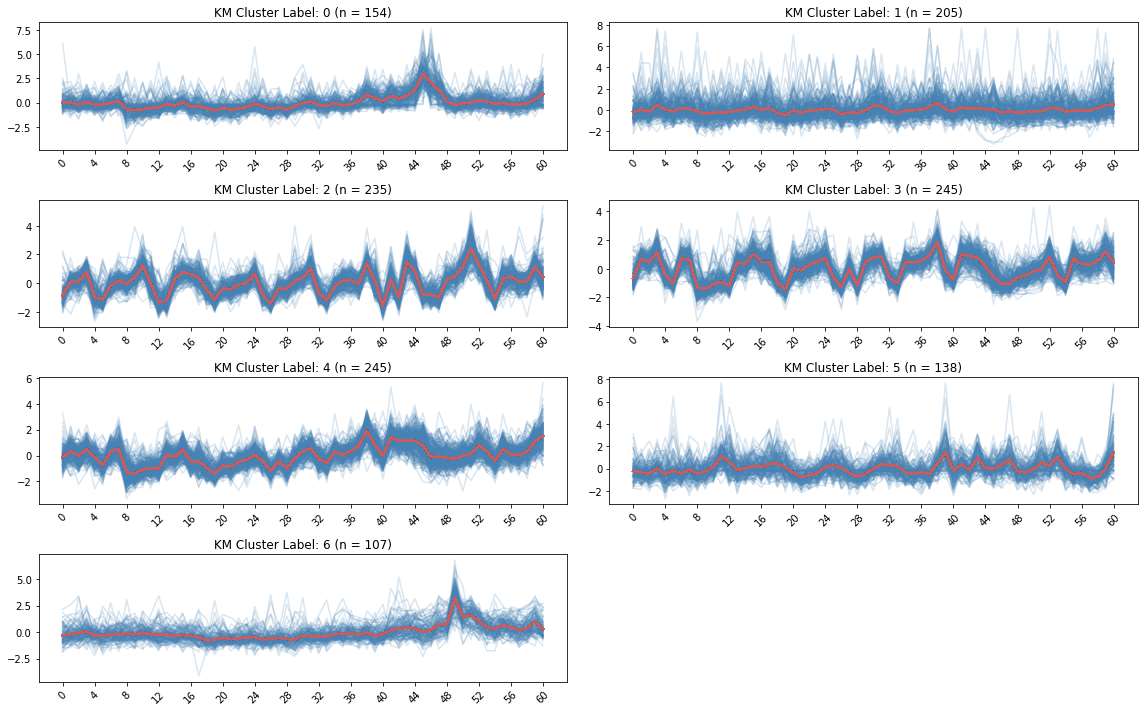

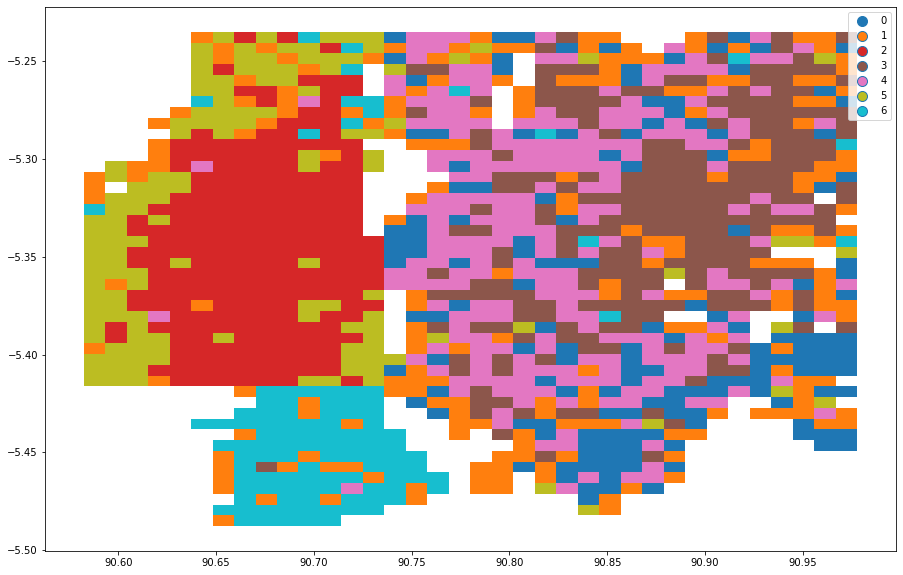

In [22]:
n_timesteps = 61
n_features = 61
n_clusters = 7
cluster_name = 'daily_norm'
apply_cluster(taz_daily, n_timesteps, n_features, n_clusters, cluster_name, tickstep=4)
plot_cluster_map(shp, taz_daily, cluster_name, n_clusters)

### 2.3.3 Hourly

In [23]:
taz_quarterly = data.groupby(['geohash6', 'quarter'])['demand'].mean().reset_index()
taz_quarterly = taz_quarterly.pivot(index='geohash6', columns='quarter', values='demand')
taz_quarterly.fillna(0, inplace=True)
assert sum(taz_quarterly.sum(axis=1) == 0) == 0
taz_quarterly = normalize_taz(taz_quarterly)
taz_quarterly['active_count'] = taz_quarterly.index.map(counts) / max_count
taz_quarterly.head(1)

quarter,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,active_count
geohash6,,,,,,,,,,,,,,,,,,,,,
qp02yc,0.817159,0.050268,-1.099626,-0.366929,0.393077,1.279391,-0.35927,-0.092664,1.007797,1.120308,...,-1.099626,-1.099626,-0.755862,-0.469505,0.511916,-0.082454,0.710992,-0.599751,-0.005873,0.098531


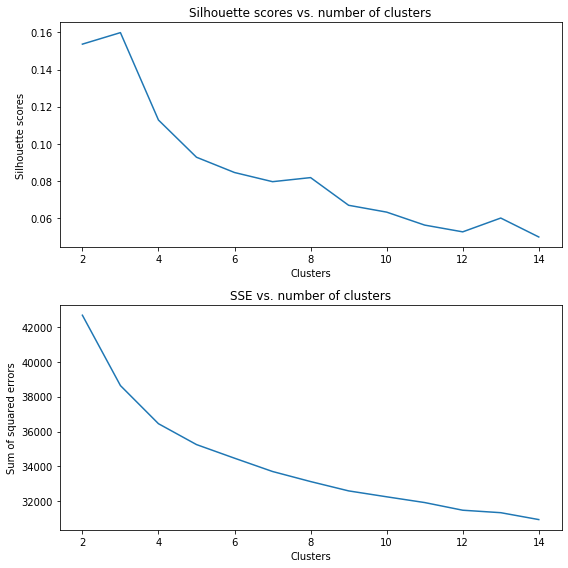

In [24]:
check_clusters(taz_quarterly, n_features=96)

Last 3 features: Index([93, 94, 95], dtype='object', name='quarter')


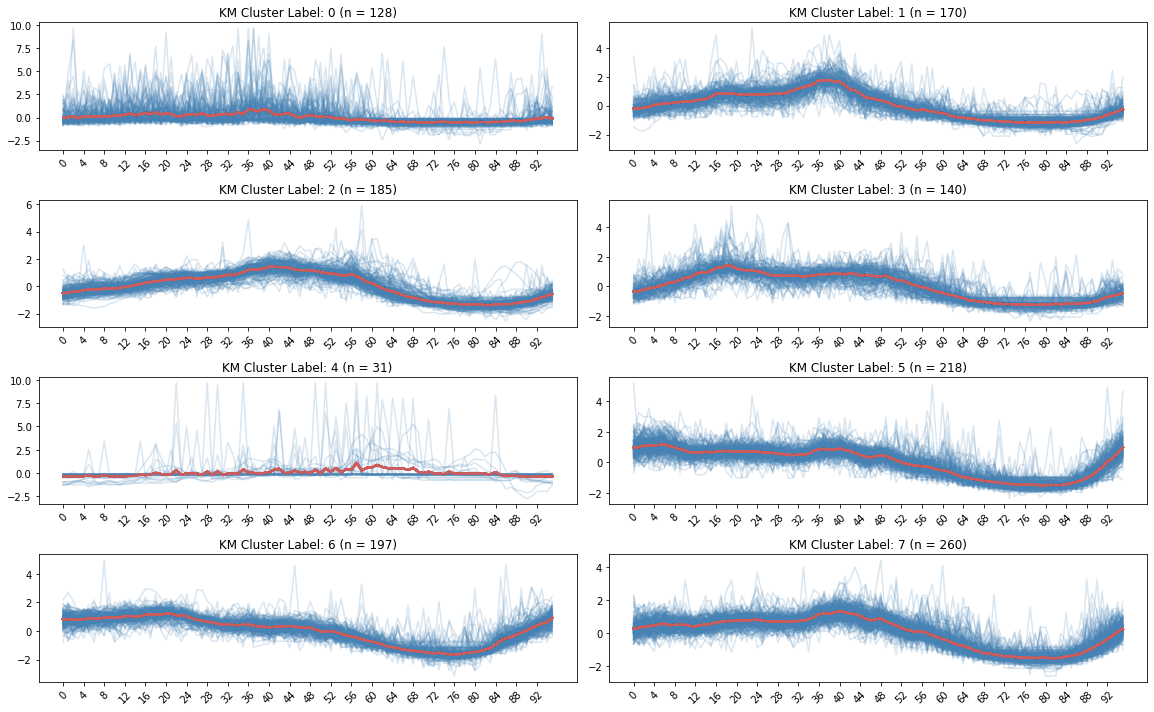

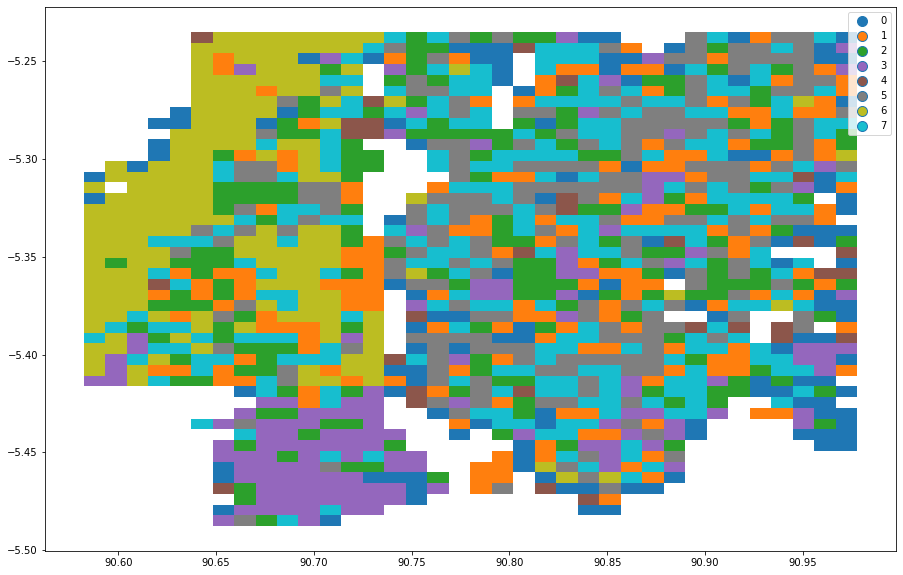

In [25]:
n_timesteps = 96
n_features = 96
n_clusters = 8
cluster_name = 'quarterly_norm'
apply_cluster(taz_quarterly, n_timesteps, n_features, n_clusters, cluster_name, tickstep=4)
plot_cluster_map(shp, taz_quarterly, cluster_name, n_clusters)

In [26]:
labels = [taz_weekly['weekly_label_7'],
          taz_weekly_norm['weekly_norm_label_8'],
          taz_daily['daily_norm_label_7'],
          taz_quarterly['quarterly_norm_label_8']]

In [27]:
output = pd.concat(labels, axis=1).reset_index()
output.columns = ['geohash6', 'label_weekly_raw', 'label_weekly', 'label_daily', 'label_quarterly']
output.to_csv(path+'zone_labels.csv', index=None)
output.head()

,geohash6,label_weekly_raw,label_weekly,label_daily,label_quarterly
0,qp02yc,0,5,1,3
1,qp02yf,0,4,6,0
2,qp02yu,0,0,1,4
3,qp02yv,0,0,1,0
4,qp02yy,0,4,1,0
